In [1]:
import odrive
from odrive.enums import *
import time
import math
import numpy as np
import sympy as sp
from sympy.utilities.lambdify import lambdify
import matplotlib.pyplot as plt
plt.ion()
import matplotlib as mpl
mpl.use('Qt5Agg')
from scipy.optimize import minimize

# FK & IK

In [2]:
(thetaL_sym, thetaR_sym) = sp.symbols("""thetaL_sym thetaR_sym """, real = True)

def T(theta, x, y):
    return sp.Matrix([[sp.cos(theta), -sp.sin(theta), x], 
                      [sp.sin(theta), sp.cos(theta), y],
                      [0, 0, 1]])

l1 = 0.09
l2 = 0.16
w  = 0.07

x_r = -w/2 + l1*sp.cos(thetaR_sym)
x_l = w/2 + l1*sp.cos(thetaL_sym)

y_r = l1*sp.sin(thetaR_sym)
y_l = l1*sp.sin(thetaL_sym)

theta3_sym = sp.atan2(y_l - y_r, x_l - x_r)
L = sp.sqrt((x_l - x_r)**2 + (y_l - y_r)**2)

FK = T(thetaL_sym, w/2, 0)@T((sp.pi - thetaL_sym + theta3_sym), l1, 0)@sp.Matrix([L/2, -sp.sqrt(l2**2 - (L/2)**2), 1])
FK = FK[:2,:]
FK_fast = lambdify((thetaR_sym, thetaL_sym), FK) # (x,y) = FK_fast(thetaR,thetaL)

J = FK.jacobian([thetaR_sym, thetaL_sym]).evalf()
J_fast = lambdify((thetaR_sym, thetaL_sym), J) # J_fast(thetaR,thetaL)

def IK_5_link(x, y, l1 = 0.09, l2 = 0.16, w = 0.07):

    def leg_wide(var):
        return np.linalg.norm([var[0], var[1] - np.pi]) 

    def x_constraint_equation(var):
    # should be equal to zero when the 
        return l1**2 - l2**2 + (x - w/2)**2 + y**2 - 2*l1*(y*np.sin(var[0]) + (x - w/2)*np.cos(var[0]))

    def y_constraint_equation(var):
        return l1**2 - l2**2 + (x + w/2)**2 + y**2 - 2*l1*(y*np.sin(var[1]) + (x + w/2)*np.cos(var[1]))

    res = minimize(leg_wide, (0.1, 9*np.pi/10), method="SLSQP", constraints= ({"type": "eq", "fun": x_constraint_equation}, 
                                                                              {"type": "eq", "fun": y_constraint_equation}))
    return (res.x[0], res.x[1])

## Connect to Odrive

In [3]:
def connect_odrive(serial):
    odrv0 = odrive.find_any(serial_number = serial, timeout = 20)
    if odrv0 is not None:
        print('Connected!')
        print('Target serial {} \t Odrive serial {}'.format(serial, odrv0.serial_number))
        print('Motor 0 calibrated: {}'.format(odrv0.axis0.motor.is_calibrated))
        print('Motor 1 calibrated: {}'.format(odrv0.axis1.motor.is_calibrated))    
    else:
        print("ODrive ({}) not found".format(serial))
    return odrv0

# odrv1 = connect_odrive("206A33A5304B")
odrv1 = connect_odrive("335C315E3536")

m0  = odrv1.axis0
m1  = odrv1.axis1

Connected!
Target serial 335C315E3536 	 Odrive serial 56471058265398
Motor 0 calibrated: True
Motor 1 calibrated: True


## Configuration Setup

In [4]:
def SetParameter(odrv0):
    current_limit = 20
    odrv0.axis0.motor.config.current_lim    = current_limit #A
    odrv0.axis1.motor.config.current_lim    = current_limit #A
    odrv0.axis0.controller.config.vel_limit = 1000000
    odrv0.axis1.controller.config.vel_limit = 1000000
    odrv0.axis0.controller.config.pos_gain  = 60
    odrv0.axis1.controller.config.pos_gain  = 60
    odrv0.axis0.controller.config.vel_integrator_gain = 0.00025
    odrv0.axis1.controller.config.vel_integrator_gain = 0.00025
    return(current_limit)

def CheckMotorError(odrv0):
    axis0error = odrv0.axis0.error 
    axis1error = odrv0.axis1.error 
    axis0motorerror = odrv0.axis0.motor.error 
    axis1motorerror = odrv0.axis1.motor.error 
    axis0controllererror = odrv0.axis0.controller.error 
    axis1controllererror = odrv0.axis0.controller.error 
    print("error:          ", axis0error, axis1error)
    print("motorerror:     ", axis0motorerror, axis1motorerror)
    print("controllererror:", axis0controllererror, axis1controllererror)
    return()

def MotorClearError(odrv0):
    odrv0.axis0.error = 0
    odrv0.axis1.error = 0
    odrv0.axis0.motor.error = 0
    odrv0.axis1.motor.error = 0
    odrv0.axis0.controller.error = 0
    odrv0.axis1.controller.error = 0
    odrv0.axis0.encoder.error = 0
    odrv0.axis1.encoder.error = 0
    return()

In [5]:
SetParameter(odrv1)
print("Parameter Set!")

Parameter Set!


In [6]:
print("odrive1")
CheckMotorError(odrv1)
MotorClearError(odrv1)
print("Error Clear!")

odrive1
error:           0 0
motorerror:      0 0
controllererror: 0 0
Error Clear!


## Motor Command

In [7]:
def Calibration(odrv0):
    odrv0.axis0.requested_state = AXIS_STATE_FULL_CALIBRATION_SEQUENCE
    odrv0.axis1.requested_state = AXIS_STATE_FULL_CALIBRATION_SEQUENCE
    print('Motor 0 calibrated: {}'.format(odrv0.axis0.motor.is_calibrated))
    print('Motor 1 calibrated: {}'.format(odrv0.axis1.motor.is_calibrated))   

def ClosedLoopControlMode(odrv0):
    odrv0.axis0.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL
    odrv0.axis1.requested_state = AXIS_STATE_CLOSED_LOOP_CONTROL

def IdleMode(odrv0):
    odrv0.axis0.requested_state = odrive.enums.AXIS_STATE_IDLE
    odrv0.axis1.requested_state = odrive.enums.AXIS_STATE_IDLE

def ControllerPositionControl(odrv0): # default mode
    odrv0.axis0.controller.config.control_mode = CTRL_MODE_POSITION_CONTROL
    odrv0.axis1.controller.config.control_mode = CTRL_MODE_POSITION_CONTROL
#     print("Control Mode :{}".format(odrv0.axis0.controller.config.control_mode))

def ControllerCurrentControl(odrv0):
    odrv0.axis0.controller.config.control_mode = CTRL_MODE_CURRENT_CONTROL
    odrv0.axis1.controller.config.control_mode = CTRL_MODE_CURRENT_CONTROL
#     print("Control Mode :{}".format(odrv0.axis0.controller.config.control_mode))

def MaxCurrentProtection(current, current_limit = 20):
    current = min(np.abs(current), current_limit) * np.sign(current) 
    return(current)

In [ ]:
Calibration(odrv1)

In [8]:
ClosedLoopControlMode(odrv1)

In [9]:
IdleMode(odrv1)

## Define zero angle

In [10]:
m0_home_pos = m0.encoder.pos_estimate
m1_home_pos = m1.encoder.pos_estimate
theta_R_home = -((m0_home_pos) / 8192 * 2 * np.pi) + np.pi
theta_L_home = -((m1_home_pos) / 8192 * 2 * np.pi)
print(m0_home_pos)
print(m1_home_pos)

-1620.767578125
1167.8134765625


## Define home location

In [11]:
m0_equilibrium_toe_pos = m0.encoder.pos_estimate
m1_equilibrium_toe_pos = m1.encoder.pos_estimate
theta_R_eq = - ((m0_equilibrium_toe_pos - m0_home_pos) / 8192 * 2 * np.pi) + np.pi
theta_L_eq = - ((m1_equilibrium_toe_pos - m1_home_pos) / 8192 * 2 * np.pi)
theta_R_eq_d = theta_R_eq / (2 * np.pi) * 360
theta_L_eq_d = theta_L_eq / (2 * np.pi) * 360
print("Odrv1 \nR:", theta_R_eq_d, "\nL:", theta_L_eq_d)

Odrv1 
R: 138.076171875 
L: 43.02520751953124


## Trajactory Generator

In [14]:
def SwingTrajectory(t_clock, UpperAMP = 0.07, StanceHeight = 0.19, StepLength = 0.18):
    
    period = 2
    percent = t_clock / period

    if (percent <= 1): # Swing
        x = -(StepLength / 2) + percent * StepLength
        y = -UpperAMP * np.sin(np.pi * percent) + StanceHeight  
        
    else: # Stay and do nothing
        x = StepLength / 2
        y = StanceHeight

    return np.array([[x], [y]])

def GoHomeTrajactory(t_clock, StanceHeight = 0.19, StepLength = 0.18, LiftHeight = 0.09):

    period = 4   
    percent = t_clock / period

    if percent >= 0 and percent < 0.25:
        x = StepLength / 2
        y = -(percent / 0.25) * LiftHeight + StanceHeight
        
    elif percent >= 0.25 and percent < 0.75:
        x = StepLength / 2 - ((percent - 0.25) / 0.5) * StepLength
        y = -LiftHeight + StanceHeight
        
    elif percent >= 0.75 and percent <= 1:
        x = -StepLength / 2
        y = -LiftHeight + StanceHeight + ((percent - 0.75) / 0.25) * LiftHeight 
        
    else:
        x = -StepLength / 2
        y = StanceHeight

    return np.array([[x], [y]])

def StepBackward(t_clock, x_pos, y_pos):
    
    step = 0.01
    period = 1
    percent = t_clock / period

    if percent <= 1: # Moving forward
        x = x_pos - percent * step
        y = y_pos 
        
    else: # Stay and do nothing
        pass

    return np.array([x, y])

def StepUpward(t_clock, x_pos, y_pos):
    
    step = 0.01
    period = 1
    percent = t_clock / period

    if percent <= 1: # Moving forward
        x = x_pos
        y = y_pos - percent * step 
        
    else: # Stay and do nothing
        pass

    return np.array([x, y])

def StepForward(t_clock, x_pos, y_pos):
    
    step = 0.01
    period = 1
    percent = t_clock / period

    if percent <= 1: # Moving forward
        x = x_pos + percent * step
        y = y_pos 
        
    else: # Stay and do nothing
        pass

    return np.array([x, y])

def from_joint_get_pos(m0_home_pos, m1_home_pos):
    
    thetaR = - ((m0.encoder.pos_estimate - m0_home_pos) / 8192 * 2 * np.pi) + np.pi
    thetaL = - ((m1.encoder.pos_estimate - m1_home_pos) / 8192 * 2 * np.pi)

    x = FK_fast(thetaR, thetaL)[0]
    y = FK_fast(thetaR, thetaL)[1]
    
    return np.array([x, y])

def from_pos_get_joint(x, y, m0_home_pos, m1_home_pos):

    theta_R = IK_5_link(x, y)[1]
    theta_L = IK_5_link(x, y)[0]
    
    m0_pos = -(theta_R - np.pi)/(2*np.pi)*8192 + m0_home_pos
    m1_pos = -theta_L/(2*np.pi)*8192 + m1_home_pos
    
    return np.array([m0_pos, m1_pos]) 

## Current Measurement

In [16]:
def current_measurement(test_cycle, m0_home_pos, m1_home_pos, measure_time = 4, step_time = 1):
    
    measured_current_m0 = []
    measured_current_m1 = []
    
    ClosedLoopControlMode(odrv1)

    count = 0
    while count < test_cycle:
        
        step = 1
        while step <= 20:
            '''
            Pausing =================================================================================
            '''
            t_pause_start = time.time()
            while time.time() - t_pause_start < measure_time:

                pass
            
            measured_current_m0.append(m0.motor.current_control.Iq_measured)
            measured_current_m1.append(m1.motor.current_control.Iq_measured)
            '''
            Stepping Backward ========================================================================
            '''
            t_step_start = time.time()
            x = from_joint_get_pos(m0_home_pos, m1_home_pos)[0]
            y = from_joint_get_pos(m0_home_pos, m1_home_pos)[1]
            
            while time.time() - t_step_start < step_time:
                
                t_clock = time.time() - t_step_start
                theta_R = IK_5_link(StepBackward(t_clock, x, y)[0],StepBackward(t_clock, x, y)[1])[1]
                theta_L = IK_5_link(StepBackward(t_clock, x, y)[0],StepBackward(t_clock, x, y)[1])[0]

                m0_pos = -(theta_R - np.pi)/(2*np.pi)*8192 + m0_home_pos
                m1_pos = -theta_L/(2*np.pi)*8192 + m1_home_pos

                m0.controller.set_pos_setpoint(m0_pos,0,0)
                m1.controller.set_pos_setpoint(m1_pos,0,0)
                
            step += 1
            
        step = 1    
        while step <= 1:
            '''
            Pausing =================================================================================
            '''
            t_pause_start = time.time()
            while time.time() - t_pause_start < measure_time:

                pass
            
            measured_current_m0.append(m0.motor.current_control.Iq_measured)
            measured_current_m1.append(m1.motor.current_control.Iq_measured)
            '''
            Stepping Upward ========================================================================
            '''
            t_step_start = time.time()
            x = from_joint_get_pos(m0_home_pos, m1_home_pos)[0]
            y = from_joint_get_pos(m0_home_pos, m1_home_pos)[1]
            
            while time.time() - t_step_start < step_time:
                
                t_clock = time.time() - t_step_start
                theta_R = IK_5_link(StepUpward(t_clock, x, y)[0],StepUpward(t_clock, x, y)[1])[1]
                theta_L = IK_5_link(StepUpward(t_clock, x, y)[0],StepUpward(t_clock, x, y)[1])[0]

                m0_pos = -(theta_R - np.pi)/(2*np.pi)*8192 + m0_home_pos
                m1_pos = -theta_L/(2*np.pi)*8192 + m1_home_pos

                m0.controller.set_pos_setpoint(m0_pos,0,0)
                m1.controller.set_pos_setpoint(m1_pos,0,0)
                
            step += 1
            
        step = 1
        while step <= 20:
            '''
            Pausing =================================================================================
            '''
            t_pause_start = time.time()
            while time.time() - t_pause_start < measure_time:

                pass
            
            measured_current_m0.append(m0.motor.current_control.Iq_measured)
            measured_current_m1.append(m1.motor.current_control.Iq_measured)
            '''
            Stepping Forward ========================================================================
            '''
            t_step_start = time.time()
            x = from_joint_get_pos(m0_home_pos, m1_home_pos)[0]
            y = from_joint_get_pos(m0_home_pos, m1_home_pos)[1]
            
            while time.time() - t_step_start < step_time:
                
                t_clock = time.time() - t_step_start
                theta_R = IK_5_link(StepForward(t_clock, x, y)[0],StepForward(t_clock, x, y)[1])[1]
                theta_L = IK_5_link(StepForward(t_clock, x, y)[0],StepForward(t_clock, x, y)[1])[0]

                m0_pos = -(theta_R - np.pi)/(2*np.pi)*8192 + m0_home_pos
                m1_pos = -theta_L/(2*np.pi)*8192 + m1_home_pos

                m0.controller.set_pos_setpoint(m0_pos,0,0)
                m1.controller.set_pos_setpoint(m1_pos,0,0)
                
            step += 1
            
        step = 1
        while step <= 1:
            '''
            Pausing =================================================================================
            '''
            t_pause_start = time.time()
            while time.time() - t_pause_start < measure_time:

                pass
            
            measured_current_m0.append(m0.motor.current_control.Iq_measured)
            measured_current_m1.append(m1.motor.current_control.Iq_measured)
            '''
            Stepping Upward ========================================================================
            '''
            t_step_start = time.time()
            x = from_joint_get_pos(m0_home_pos, m1_home_pos)[0]
            y = from_joint_get_pos(m0_home_pos, m1_home_pos)[1]
            
            while time.time() - t_step_start < step_time:
                
                t_clock = time.time() - t_step_start
                theta_R = IK_5_link(StepUpward(t_clock, x, y)[0],StepUpward(t_clock, x, y)[1])[1]
                theta_L = IK_5_link(StepUpward(t_clock, x, y)[0],StepUpward(t_clock, x, y)[1])[0]

                m0_pos = -(theta_R - np.pi)/(2*np.pi)*8192 + m0_home_pos
                m1_pos = -theta_L/(2*np.pi)*8192 + m1_home_pos

                m0.controller.set_pos_setpoint(m0_pos,0,0)
                m1.controller.set_pos_setpoint(m1_pos,0,0)
                
            step += 1
            
        count += 1
    
    '''
    Last row of data has to be collected separately
    '''
    step = 1
    while step <= 21:
        '''
        Pausing =================================================================================
        '''
        t_pause_start = time.time()
        while time.time() - t_pause_start < measure_time:

            pass

        measured_current_m0.append(m0.motor.current_control.Iq_measured)
        measured_current_m1.append(m1.motor.current_control.Iq_measured)
        '''
        Stepping Backward ========================================================================
        '''
        t_step_start = time.time()
        x = from_joint_get_pos(m0_home_pos, m1_home_pos)[0]
        y = from_joint_get_pos(m0_home_pos, m1_home_pos)[1]

        while time.time() - t_step_start < step_time:

            t_clock = time.time() - t_step_start
            theta_R = IK_5_link(StepBackward(t_clock, x, y)[0],StepBackward(t_clock, x, y)[1])[1]
            theta_L = IK_5_link(StepBackward(t_clock, x, y)[0],StepBackward(t_clock, x, y)[1])[0]

            m0_pos = -(theta_R - np.pi)/(2*np.pi)*8192 + m0_home_pos
            m1_pos = -theta_L/(2*np.pi)*8192 + m1_home_pos

            m0.controller.set_pos_setpoint(m0_pos,0,0)
            m1.controller.set_pos_setpoint(m1_pos,0,0)

        step += 1
        
    
    return measured_current_m0, measured_current_m1

In [17]:
i = 1
test_count = 3
current_m0 = np.zeros((test_count,231))
current_m1 = np.zeros((test_count,231))

while i <= test_count:
    
    ClosedLoopControlMode(odrv1)

    x_start = 0.1
    y_start = 0.19
    
    time.sleep(4)

    m0_pos = from_pos_get_joint(x_start, y_start, m0_home_pos, m1_home_pos)[0]
    m1_pos = from_pos_get_joint(x_start, y_start, m0_home_pos, m1_home_pos)[1]

    m0.controller.set_pos_setpoint(m0_pos,0,0)
    m1.controller.set_pos_setpoint(m1_pos,0,0)

    time.sleep(2)
    
    measured_current_m0, measured_current_m1 = current_measurement(5, m0_home_pos, m1_home_pos)
    
    current_m0[i-1,:] = measured_current_m0[:]
    current_m1[i-1,:] = measured_current_m1[:]
    
    i += 1


In [ ]:
IdleMode(odrv1)

## Colect the current data 

length of data: 231 231


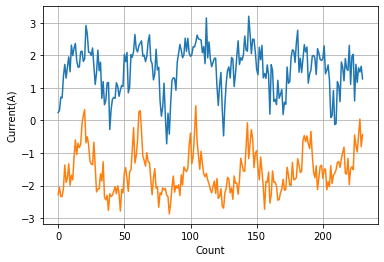

In [22]:
avg_current_m0 = current_m0.sum(axis=0)/test_count
avg_current_m1 = current_m1.sum(axis=0)/test_count

print('length of data:',len(avg_current_m0), len(avg_current_m1))

# avg_current = np.sum([np.absolute(avg_current_m0), np.absolute(avg_current_m1)], axis=0)
# plt.plot(np.arange(len(avg_current)), avg_current)

plt.plot(np.arange(len(avg_current_m0)),avg_current_m0)
plt.plot(np.arange(len(avg_current_m1)),avg_current_m1)
plt.xlabel("Count")
plt.ylabel("Current(A)")
plt.grid()
plt.show()

# print(*avg_current_m1, sep = ', ')

## Pre-calculated Current Map

In [ ]:
%matplotlib qt

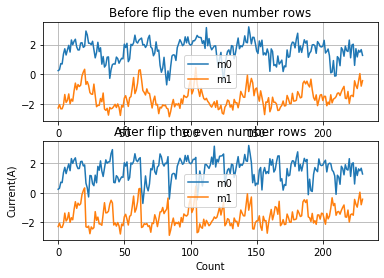

In [35]:
'''
These are the average currents of 3 test cycles, each cycle has 231 data points.
Method to measured the current: Position control mode with pos_gain = 60, vel_integraotr_gain = 0.00025
'''
avg_current_m0 = np.array([0.24385765194892883, 0.3094293673833211, 0.7187509934107462, 0.6929809252421061, 1.3647583325703938, 1.7217425505320232, 1.300304889678955, 1.648040533065796, 1.9535056352615356, 1.4974501132965088, 2.31532613436381, 1.9920955499013264, 2.2254158655802407, 2.3666520913441977, 1.847597360610962, 1.6390361388524373, 1.6461957693099976, 2.1099076668421426, 2.1325478553771973, 1.8163514137268066, 1.8888504107793171, 2.9206464290618896, 2.6543094317118325, 2.0987207889556885, 2.092839320500692, 1.999744137128194, 2.2282211780548096, 1.6792758305867512, 1.10627414782842, 1.4703027407328289, 2.1606341203053794, 1.5280054410298665, 1.7889078855514526, 0.6789019306500753, 1.1961313486099243, 0.48277286688486737, 0.612623006105423, 1.1495956977208455, 1.1725813150405884, -0.2772788455088933, 0.332332968711853, 0.6521611015001932, 0.7043842375278473, 0.6808854738871256, 1.1591075261433919, 1.054255445798238, 0.743113378683726, 0.9329129457473755, 1.0790797074635823, 1.0422943433125813, 2.032093127568563, 1.8056693871815999, 2.0906312465667725, 0.849586566289266, 1.029306689898173, 2.0222384929656982, 1.9436176617940266, 2.126174290974935, 2.641770919164022, 2.1976657708485923, 2.1059587001800537, 2.2957820892333984, 2.3773279984792075, 2.4455095132191977, 1.975038210550944, 2.00803812344869, 1.8102043867111206, 1.9721685250600178, 2.4267675081888833, 2.6304352283477783, 1.8454880317052205, 1.744606852531433, 1.2482138872146606, 1.4302936792373657, 2.188453753789266, 1.5512415568033855, 1.631245772043864, 0.6038171450297037, 0.13339702288309732, 0.4121633768081665, 1.143872857093811, 0.14988629023234049, -0.7167718211809794, 0.22382322947184244, -0.4171148935953776, 0.511415441830953, 1.2329217195510864, 1.3153606255849202, 1.2904865741729736, 0.9308393001556396, 1.7994898955027263, 2.0531906286875405, 2.3358784914016724, 2.161727865537008, 1.9283878405888875, 2.015161315600077, 2.5283345381418862, 2.1249244610468545, 2.5240070819854736, 2.0664217869440713, 1.9704421758651733, 2.0232108434041343, 2.265923102696737, 2.258591572443644, 2.3936071395874023, 2.6251205603281655, 2.5077221393585205, 2.4912234942118325, 2.473044236501058, 2.0820539792378745, 2.2661094268163047, 1.745513677597046, 3.1524131298065186, 1.9257471561431885, 2.4136871496836343, 1.8905646800994873, 1.6534742911656697, 1.7814180850982666, 1.9101956288019817, 1.9164384206136067, 1.0571859280268352, 0.4606725573539734, 1.091152509053548, 1.476565678914388, 0.3367473979791005, -0.47332294782002765, 0.5010560154914856, 1.1517316897710164, 1.5442677736282349, 1.6470460096995037, 1.3049650986989338, 1.9339747428894043, 1.8914369742075603, 1.0414698521296184, 1.4385973612467449, 1.969805081685384, 2.447709321975708, 1.7240252097447712, 1.928009271621704, 1.8547149499257405, 2.0282653172810874, 2.594468593597412, 2.1630724668502808, 2.127838452657064, 3.202412764231364, 2.6751373608907065, 2.051024317741394, 2.498440663019816, 2.4904049237569175, 2.088454325993856, 1.5678453644116719, 1.406442642211914, 2.250063101450602, 1.866146167119344, 2.304741621017456, 1.309440056482951, 1.4436272780100505, 1.2946491241455078, 1.7087289492289226, 1.3948681354522705, 0.19499091307322183, 1.7129745086034138, 1.5390563408533733, 0.5865997423728307, 0.6500785102446874, 0.4878290295600891, 1.2354771693547566, 0.6837249596913656, 0.8018242716789246, 0.9551982680956522, 0.1827294925848643, 0.5636499921480814, 0.49909430742263794, 1.643161416053772, 1.1430108547210693, 1.1951600313186646, 1.9328319231669109, 2.168688098589579, 2.1448940436045327, 1.781290332476298, 2.3837035497029624, 2.772059122721354, 1.4827723900477092, 1.9108161528905232, 1.4763656457265217, 1.8926761547724407, 2.33011531829834, 2.10691237449646, 2.256103992462158, 1.145057241121928, 1.4253995815912883, 1.5443984667460124, 1.977695902188619, 2.0023202896118164, 1.9223989248275757, 1.4143034219741821, 2.206624666849772, 2.071223735809326, 1.874717076619466, 1.8417784770329793, 1.8987433910369873, 2.293064753214518, 1.4327460527420044, 1.5438967148462932, 1.7068617741266887, 1.2466908693313599, 0.09146864463885625, 0.14497573177019754, 0.9241856733957926, -0.12775465846061707, -0.10185965398947398, 1.191097617149353, 1.0708035031954448, 0.5770930250485738, 1.7961201270421345, 1.6440867980321248, 1.2170868714650471, 1.90204922358195, 1.5947521527608235, 1.5382156769434612, 2.3090309302012124, 1.1101342837015789, 1.9734142621358235, 2.0313257376352944, 0.5989607771237692, 1.7254005273183186, 1.169793168703715, 1.6195868253707886, 1.487960656483968, 1.6649297873179119, 1.2752639849980671])
avg_current_m1 = np.array([-2.2797098954518638, -2.053180376688639, -2.3361454010009766, -2.3334283034006753, -2.081712563832601, -1.3692905108133953, -1.9024568398793538, -1.7690024773279827, -1.3322250843048096, -1.994081695874532, -1.6818673610687256, -1.8202637434005737, -1.1361668109893799, -0.5988062421480814, -1.048218051592509, -0.6973060766855875, -0.8300726811091105, -0.7380097508430481, -0.11959755669037501, 0.14762013157208762, 0.3353431175152461, -0.6869473854700724, -0.5016278525193533, -0.7577384114265442, -1.2399080594380696, -1.340093731880188, -1.3555967807769775, -0.666299303372701, -1.4233221213022869, -2.193217118581136, -2.1028990745544434, -2.103356917699178, -1.6393461624781291, -1.859449823697408, -1.269327203432719, -2.348478396733602, -2.4404971599578857, -2.3028586705525718, -2.7627042134602866, -2.24586812655131, -2.335736115773519, -2.295964320500692, -2.1735856533050537, -2.0345710118611655, -2.249800523122152, -2.0066835085550943, -2.2386058966318765, -2.7825369834899902, -2.1118180751800537, -2.2224119504292807, -1.6119219462076824, -1.4509632587432861, -1.7773346900939941, -2.1761478583017984, -1.5867713292439778, -1.5122490723927815, -0.9182511766751608, -0.2192233751217524, -1.308614174524943, -1.0779201189676921, -0.6103412806987762, 0.266292467713356, 0.3024089535077413, -0.3552477955818176, -1.0995302597681682, -1.2309869925181072, -1.4033260742823284, -0.9891932805379232, -1.2713457743326824, -1.2932180563608806, -1.8089810212453206, -2.281296650568644, -1.770991365114848, -1.479876200358073, -2.0801594654719033, -2.035137176513672, -2.664177497227987, -2.2222375869750977, -2.280874570210775, -2.070718685785929, -2.1321224371592202, -2.0859897136688232, -2.294501622517904, -2.3432594935099282, -2.8702147006988525, -2.5244043668111167, -2.0505572160085044, -1.70535413424174, -2.203084707260132, -1.996114452679952, -2.0780444145202637, -1.9735807577768962, -2.3072122732798257, -1.6672333876291912, -1.9841952323913574, -1.4278603792190552, -1.5234063069025676, -1.5701942443847656, -1.460862159729004, -0.7478309075037638, -0.3853119711081187, -1.3322337865829468, -1.1077086130777996, -0.41606027881304425, 0.45204410950342816, -0.6481122374534607, -1.087979833285014, -1.4994410276412964, -0.9439000487327576, -1.322035789489746, -1.6403996149698894, -1.7279959917068481, -1.6262753009796143, -1.8283069531122844, -1.9439634482065837, -2.119074741999308, -2.2233635584513345, -2.0330498218536377, -1.8607685565948486, -2.2394651571909585, -1.783077319463094, -2.394257386525472, -2.329181512196859, -2.095521926879883, -2.630920966466268, -2.694347381591797, -2.2236881256103516, -2.0829123655954995, -1.7431803544362385, -1.8088794549306233, -2.2208834489186606, -2.0757440328598022, -2.420562744140625, -1.7030529181162517, -1.9283218781153362, -1.9219011068344116, -2.2662204106648765, -1.8367143472035725, -1.1591898202896118, -1.3650212685267131, -1.5507978200912476, -1.5597504774729412, -0.8181673884391785, -0.06766634806990623, -1.1718734502792358, -0.7329153219858805, -0.2809777061144511, -0.5715944568316141, -1.4501049915949504, -0.9978561004002889, -0.9296558300654093, -1.458973487218221, -1.8228953679402669, -1.123289982477824, -1.5559649467468262, -2.038268248240153, -2.7279580434163413, -1.8738028605779011, -1.8974505265553792, -1.5848116079966228, -2.53731902440389, -2.2780799070994058, -1.5509647925694783, -1.8995410203933716, -1.8916672468185425, -2.0144755442937217, -2.4499480724334717, -2.430097977320353, -2.221113443374634, -2.1024104754130044, -1.808496117591858, -2.144047657648722, -2.1213815609614053, -1.4347606499989827, -1.6695444583892822, -1.9843899408976238, -1.9912807941436768, -1.2884901960690816, -1.8188876310984294, -1.8037696679433186, -1.7592846155166626, -1.1740437348683674, -1.3681784868240356, -1.5993361473083496, -1.5554521083831787, -0.6082061529159546, -0.46297821402549744, -0.6529894868532816, -0.4714416066805522, -0.7206048369407654, -0.862498422463735, -0.3330726313094298, -1.0443281531333923, -1.5748084783554077, -1.7589613199234009, -1.392319917678833, -2.1246463457743325, -1.7696581681569417, -1.4065850575764973, -1.3755933443705242, -1.7766231298446655, -1.4913920561472576, -1.4969498713811238, -2.1290204524993896, -1.8802826404571533, -2.0364091396331787, -1.3890225092569988, -1.9366425673166912, -1.6821291049321492, -1.6241964896519978, -1.5163408120473225, -1.2886511882146199, -1.2609231074651082, -1.4418997764587402, -1.183966875076294, -0.9812319080034891, -0.81937309106191, -1.6255487998326619, -1.6474672158559163, -1.1632002194722493, -1.9732113281885784, -1.4739481608072917, -1.424432675043742, -1.5124091307322185, -0.44272298614184064, -0.7685344616572062, -0.9675639669100443, -0.4578015406926473, 0.0446436715622743, -0.8034603794415792, -0.43346485992272693])
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(avg_current_m0)),avg_current_m0)
plt.plot(np.arange(len(avg_current_m1)),avg_current_m1)
plt.title('Before flip the even number rows')
plt.legend(['m0','m1'])
plt.grid()

avg_current_m0 = avg_current_m0.reshape((11,21))
avg_current_m1 = avg_current_m1.reshape((11,21))

'''
Flip the even number rows 
'''
for row_index in range(len(avg_current_m0)):
    if row_index % 2 != 0:
        avg_current_m0[row_index, :] = np.flip(avg_current_m0[row_index, :])
        avg_current_m1[row_index, :] = np.flip(avg_current_m1[row_index, :])
    else:
        pass

plt.subplot(2, 1, 2)
plt.plot(np.arange(len(avg_current_m0.reshape((231,)))),avg_current_m0.reshape((231,)))
plt.plot(np.arange(len(avg_current_m1.reshape((231,)))),avg_current_m1.reshape((231,)))
plt.title('After flip the even number rows')
plt.legend(['m0','m1'])
plt.xlabel("Count")
plt.ylabel("Current(A)")
plt.grid()
plt.show()

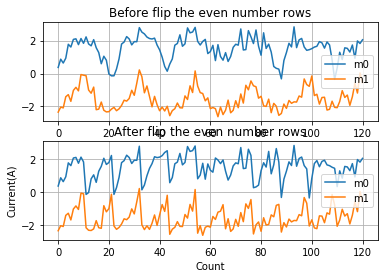

In [23]:
# '''
# These are the average currents of 4 test cycles, each cycle has 121 data points.
# Method to measured the current: Position control mode with pos_gain = 60, vel_integraotr_gain = 0.00025
# '''
# avg_current_m0 = np.array([0.3708595186471939, 0.8724643141031265, 0.637814074754715, 0.9347917139530182, 1.7776480317115784, 1.6103478074073792, 2.0742243230342865, 2.109980523586273, 1.7564296126365662, 2.1271666884422302, 1.8355320990085602, 2.226725161075592, 1.7993009984493256, 1.6842229962348938, 2.05860099196434, 1.5684598088264465, 1.2731155455112457, 0.595463365316391, 1.050559476017952, 0.8083603754639626, -0.02389223873615265, -0.1396864652633667, -0.13670922629535198, 0.27508267015218735, 0.8926088213920593, 1.7928234934806824, 1.9140808880329132, 2.2444345355033875, 2.1029508113861084, 1.740705281496048, 1.9396654665470123, 1.933881789445877, 2.7901609539985657, 2.5171558260917664, 2.40855073928833, 2.216974198818207, 2.127939850091934, 2.0990752577781677, 2.150691509246826, 1.7302857339382172, 1.4385770708322525, 0.9968220442533493, 0.4310964569449425, 0.14074579626321793, 0.5747113674879074, 0.8865684419870377, 1.722853422164917, 1.8258241415023804, 2.3527393341064453, 1.6568281650543213, 1.8041443228721619, 2.7725020051002502, 2.4738177061080933, 2.5235785841941833, 2.805095851421356, 1.9544163048267365, 1.7332798540592194, 1.9517343044281006, 2.076316863298416, 1.212203487753868, 1.3334429860115051, 1.7145720422267914, 0.7868459895253181, 1.7543316781520844, 1.038301408290863, 0.8115620762109756, 1.2708888053894043, 0.7335805743932724, 1.0361691415309906, 1.5920197665691376, 1.7786750495433807, 1.72489732503891, 2.7094558477401733, 1.4316207468509674, 1.4548529088497162, 2.6072221994400024, 2.235467493534088, 1.8211382925510406, 2.6477816700935364, 1.6615866720676422, 1.1137074530124664, 2.4746830463409424, 1.5240958333015442, 1.7863006889820099, 1.3032013773918152, 0.4279482066631317, 0.31702274829149246, 0.2691124826669693, -0.3225937932729721, 0.7908381819725037, 1.2773511558771133, 1.8402895033359528, 1.6169182360172272, 2.8364070057868958, 1.5738559365272522, 2.0443610846996307, 2.132605642080307, 1.6133490800857544, 1.4118705987930298, 1.4489381909370422, 1.5132675468921661, 1.607796460390091, 1.6558754742145538, 1.9402512907981873, 1.866967260837555, 1.5440247058868408, 1.918771892786026, 1.7346499264240265, 0.8358163386583328, -0.35322363674640656, 0.3376719020307064, 1.293826311826706, 0.8517297506332397, 1.5623725056648254, 1.530597671866417, 1.3064279854297638, 1.733636885881424, 0.9261720776557922, 1.9802054464817047, 1.8243719935417175, 2.0521022975444794])
# avg_current_m1 = np.array([-2.344711720943451, -2.0386922359466553, -2.0868042707443237, -1.408838540315628, -1.281736671924591, -1.688317596912384, -1.0236927568912506, -0.8377259373664856, -1.0512755811214447, -0.06025807000696659, -0.10058611817657948, -0.13029587268829346, -1.0011743754148483, -1.1957809627056122, -0.8232879042625427, -2.196291744709015, -2.1620090007781982, -1.73191636800766, -2.2315893173217773, -2.329719662666321, -2.315651834011078, -2.162998914718628, -2.0550307035446167, -2.2578927874565125, -2.145242393016815, -1.9357427060604095, -1.6188954412937164, -1.673589825630188, -1.516703873872757, -1.0164912343025208, -1.3218061923980713, -0.5815896689891815, 0.21907244250178337, -0.1906944178044796, -1.170295923948288, -0.7537384182214737, -1.384877860546112, -2.022313266992569, -1.3862969279289246, -1.893915742635727, -2.260924994945526, -2.042952388525009, -2.275498867034912, -1.9874057173728943, -2.559934139251709, -2.2518293261528015, -2.1352787017822266, -1.7917175590991974, -2.0793351531028748, -2.088988780975342, -1.3577812016010284, -1.57594034075737, -0.7462266832590103, -1.1524448692798615, 0.1587712373584509, -0.7609126269817352, -1.1581297814846039, -1.2148926854133606, -1.6577969193458557, -1.4783520102500916, -2.1317585706710815, -2.063448905944824, -2.1343913674354553, -2.621922016143799, -2.034304767847061, -2.493496000766754, -2.2262198328971863, -1.613978773355484, -2.3852499127388, -2.2333900332450867, -1.6512779295444489, -2.075892984867096, -1.240388959646225, -1.7938015162944794, -0.7120935469865799, -0.988139808177948, -0.4503035470843315, -0.7435515075922012, -0.8022726327180862, -1.4958509802818298, -1.3814692199230194, -1.9619775116443634, -1.9969612658023834, -1.5549304783344269, -2.3773847222328186, -1.8105084300041199, -1.987540602684021, -2.5398722290992737, -2.4244906902313232, -1.8531713783740997, -2.115117311477661, -1.63482666015625, -1.8077073991298676, -1.7200497388839722, -1.7318595945835114, -1.364015519618988, -1.4354756474494934, -0.327408529818058, -0.6693601757287979, -0.7775009274482727, -0.14703937992453575, -1.337251365184784, -1.2582655549049377, -1.8573402166366577, -1.4560569524765015, -1.4405898749828339, -2.2181840538978577, -2.1721131205558777, -1.681341677904129, -2.056821256875992, -2.0728140473365784, -1.6991605162620544, -1.0393314212560654, -1.4526692032814026, -1.3072746992111206, -1.9312063455581665, -1.4010349810123444, -0.5876418501138687, -1.1842252910137177, 0.03598788194358349, -0.5550741478800774])
# plt.subplot(2, 1, 1)
# plt.plot(np.arange(len(avg_current_m0)),avg_current_m0)
# plt.plot(np.arange(len(avg_current_m1)),avg_current_m1)
# plt.title('Before flip the even number rows')
# plt.legend(['m0','m1'])
# plt.grid()

# avg_current_m0 = avg_current_m0.reshape((11,11))
# avg_current_m1 = avg_current_m1.reshape((11,11))

# '''
# Flip the even number rows 
# '''
# for row_index in range(len(avg_current_m0)):
#     if row_index % 2 != 0:
#         avg_current_m0[row_index, :] = np.flip(avg_current_m0[row_index, :])
#         avg_current_m1[row_index, :] = np.flip(avg_current_m1[row_index, :])
#     else:
#         pass

# plt.subplot(2, 1, 2)
# plt.plot(np.arange(len(avg_current_m0.reshape((121,)))),avg_current_m0.reshape((121,)))
# plt.plot(np.arange(len(avg_current_m1.reshape((121,)))),avg_current_m1.reshape((121,)))
# plt.title('After flip the even number rows')
# plt.legend(['m0','m1'])
# plt.xlabel("Count")
# plt.ylabel("Current(A)")
# plt.grid()
# plt.show()

## Interpolate Current Map

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 21
[ 0  1  2  3  4  5  6  7  8  9 10] 11


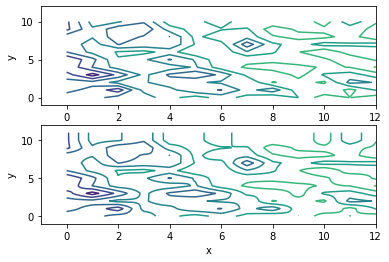

[[-2.2797099  -2.05318038 -2.3361454  -2.3334283  -2.08171256 -1.36929051
  -1.90245684 -1.76900248 -1.33222508 -1.9940817  -1.68186736 -1.82026374
  -1.13616681 -0.59880624 -1.04821805 -0.69730608 -0.83007268 -0.73800975
  -0.11959756  0.14762013  0.33534312]
 [-2.29596432 -2.33573612 -2.24586813 -2.76270421 -2.30285867 -2.44049716
  -2.3484784  -1.2693272  -1.85944982 -1.63934616 -2.10335692 -2.10289907
  -2.19321712 -1.42332212 -0.6662993  -1.35559678 -1.34009373 -1.23990806
  -0.75773841 -0.50162785 -0.68694739]
 [-2.17358565 -2.03457101 -2.24980052 -2.00668351 -2.2386059  -2.78253698
  -2.11181808 -2.22241195 -1.61192195 -1.45096326 -1.77733469 -2.17614786
  -1.58677133 -1.51224907 -0.91825118 -0.21922338 -1.30861417 -1.07792012
  -0.61034128  0.26629247  0.30240895]
 [-2.34325949 -2.29450162 -2.08598971 -2.13212244 -2.07071869 -2.28087457
  -2.22223759 -2.6641775  -2.03513718 -2.08015947 -1.4798762  -1.77099137
  -2.28129665 -1.80898102 -1.29321806 -1.27134577 -0.98919328 -1.4033

In [36]:
from scipy import interpolate

x = np.arange(0, 21, 1)
print(x, len(x))

y = np.arange(0, 11, 1)
print(y, len(y))

z = avg_current_m0
f_m0_current = interpolate.interp2d(x, y, z)
zz = avg_current_m1
f_m1_current = interpolate.interp2d(x, y, zz)

xnew = np.arange(0, 21, 0.001)
ynew = np.arange(0, 11, 0.001)
znew = f_m0_current(xnew, ynew)

plt.subplot(2, 1, 1)
plt.contour(x, y, z)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-1, 12)
plt.ylim(-1, 12)

plt.subplot(2, 1, 2)
plt.contour(xnew, ynew, znew)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-1, 12)
plt.ylim(-1, 12)
plt.show()

print(zz)

## Test Interpolate

In [53]:
x_pos = 0.095
y_pos = 0.19

i = -100*(x_pos) + 10
j = -100*(y_pos) + 19

f_m1_current(i, j)

array([-2.16644514])

In [ ]:
%matplotlib qt

## Run test

In [54]:
"""
k = [kx,0 ]  c = [cx,0 ]
    [0 ,ky]      [0 ,cy]

"""
def compliance_gravity(theta_R, theta_L):
    
    x_pos = FK_fast(theta_R, theta_L)[0]
    y_pos = FK_fast(theta_R, theta_L)[1]
    
    current = np.array([f_m0_current(-100*(x_pos)+10, -100*(y_pos)+19), 
                        f_m1_current(-100*(x_pos)+10, -100*(y_pos)+19)])
    
    return current

In [ ]:
ControllerCurrentControl(odrv1)

In [56]:
def run_compliance_gravity_test(test_time):
    
    ClosedLoopControlMode(odrv1)
    
    t_start = time.time()
    
    while time.time() - t_start < test_time:

        theta_R = - ((m0.encoder.pos_estimate - m0_home_pos) / 8192 * 2 * np.pi) + np.pi
        theta_L = - ((m1.encoder.pos_estimate - m1_home_pos) / 8192 * 2 * np.pi)
        vel_R = - (m0.encoder.vel_estimate / 8192 * 2 * np.pi)
        vel_L = - (m1.encoder.vel_estimate / 8192 * 2 * np.pi)

        current = compliance_gravity(theta_R, theta_L)
        # Motor current = Current - Damp Current
        m0_current_R = current[0] - np.array(0.5 * vel_R)
        m1_current_L = current[1] - np.array(0.5 * vel_L)

        m0.controller.set_current_setpoint(-MaxCurrentProtection(m0_current_R))
        m1.controller.set_current_setpoint(-MaxCurrentProtection(m1_current_L))

In [60]:
run_compliance_gravity_test(1)

In [61]:
IdleMode(odrv1)